## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],
              regularization=None, dropout=None, batch_normalization=None):
    """Code Here
    建立你的神經網路
    """
    if regularization:
        regularization = regularization()
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularization,
                                   activation='relu',
                                   name='hiddend_layer'+str(i+1))(input_layer)
            if batch_normalization:
                x = keras.layers.BatchNormalization()(x)
            if dropout:
                x = keras.layers.Dropout(dropout)(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   kernel_regularizer=regularization,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            if batch_normalization:
                x = keras.layers.BatchNormalization()(x)
            if dropout:
                x = keras.layers.Dropout(dropout)(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
regularization = [None, keras.regularizers.l1, keras.regularizers.l2]
dropout = [0, 0.2]
batch_normalization = [None, True]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for reg in regularization:
    for drp in dropout:
        for bn in batch_normalization:
            
            keras.backend.clear_session() # 把舊的 Graph 清掉
            if reg:
                reg_name = reg.__name__
            else:
                reg_name = 'None'
            print('Experiment with regularization ={}, dropout={}, batch_normalization={}'.format(reg_name, str(drp), str(bn)))
            model = build_mlp(input_shape=x_train.shape[1:], regularization=reg, dropout=drp, batch_normalization=bn)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "reg={},dropout={},batch_norm={}".format(reg_name, str(drp), str(bn))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Experiment with regularization =None, dropout=0, batch_normalization=None
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hiddend_layer1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
____________________________________________________

50000/50000 [==============================] - 3s 53us/step - loss: 0.9055 - acc: 0.6827 - val_loss: 1.3557 - val_acc: 0.5369
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.8941 - acc: 0.6881 - val_loss: 1.3725 - val_acc: 0.5339
Epoch 50/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.8902 - acc: 0.6874 - val_loss: 1.4125 - val_acc: 0.5286
Experiment with regularization =None, dropout=0, batch_normalization=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hiddend_layer1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
______________________________________________________________

50000/50000 [==============================] - 3s 63us/step - loss: 0.2132 - acc: 0.9386 - val_loss: 2.3313 - val_acc: 0.4654
Epoch 47/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1941 - acc: 0.9470 - val_loss: 2.2874 - val_acc: 0.4729
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1832 - acc: 0.9488 - val_loss: 2.3881 - val_acc: 0.4607
Epoch 49/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1761 - acc: 0.9518 - val_loss: 2.5118 - val_acc: 0.4648
Epoch 50/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1594 - acc: 0.9587 - val_loss: 2.3696 - val_acc: 0.4889
Experiment with regularization =None, dropout=0.2, batch_normalization=None
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

Epoch 42/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2870 - acc: 0.5430 - val_loss: 1.3191 - val_acc: 0.5288
Epoch 43/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.2776 - acc: 0.5438 - val_loss: 1.3191 - val_acc: 0.5295
Epoch 44/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.2730 - acc: 0.5455 - val_loss: 1.3079 - val_acc: 0.5339
Epoch 45/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2612 - acc: 0.5505 - val_loss: 1.3211 - val_acc: 0.5240
Epoch 46/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2612 - acc: 0.5515 - val_loss: 1.3156 - val_acc: 0.5278
Epoch 47/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2526 - acc: 0.5526 - val_loss: 1.3305 - val_acc: 0.5298
Epoch 48/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2467 - acc: 0.5544 - val_loss: 1.2965 - val_acc: 0.5333
Epoch 49/50
50000/50000 [=========

50000/50000 [==============================] - 3s 64us/step - loss: 1.2441 - acc: 0.5545 - val_loss: 1.3539 - val_acc: 0.5133
Epoch 38/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2392 - acc: 0.5547 - val_loss: 1.3279 - val_acc: 0.5236
Epoch 39/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2326 - acc: 0.5565 - val_loss: 1.3499 - val_acc: 0.5181
Epoch 40/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.2311 - acc: 0.5587 - val_loss: 1.3552 - val_acc: 0.5160
Epoch 41/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2300 - acc: 0.5588 - val_loss: 1.3529 - val_acc: 0.5118
Epoch 42/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2243 - acc: 0.5619 - val_loss: 1.3559 - val_acc: 0.5159
Epoch 43/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2156 - acc: 0.5638 - val_loss: 1.3801 - val_acc: 0.5127
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 55us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 39/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 40/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 41/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 42/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.4626 - acc: 0.0970 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.4626 - acc: 0.0979 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 45/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 64us/step - loss: 2.1881 - acc: 0.3982 - val_loss: 2.9308 - val_acc: 0.2106
Epoch 37/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.1825 - acc: 0.3971 - val_loss: 3.0399 - val_acc: 0.2004
Epoch 38/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.1801 - acc: 0.3997 - val_loss: 2.8982 - val_acc: 0.2856
Epoch 39/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.1854 - acc: 0.3995 - val_loss: 2.4640 - val_acc: 0.3027
Epoch 40/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.1787 - acc: 0.3987 - val_loss: 2.4932 - val_acc: 0.2963
Epoch 41/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.1892 - acc: 0.4005 - val_loss: 2.9958 - val_acc: 0.2239
Epoch 42/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.1855 - acc: 0.3979 - val_loss: 2.8987 - val_acc: 0.2569
Epoch 43/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 35/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 36/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 37/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4626 - acc: 0.1003 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 38/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4626 - acc: 0.0971 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 39/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4626 - acc: 0.0994 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 40/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 41/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 66us/step - loss: 2.4142 - acc: 0.3031 - val_loss: 2.4911 - val_acc: 0.2801
Epoch 30/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4141 - acc: 0.3030 - val_loss: 2.7467 - val_acc: 0.2248
Epoch 31/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4176 - acc: 0.3015 - val_loss: 3.2758 - val_acc: 0.1480
Epoch 32/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4162 - acc: 0.3054 - val_loss: 3.0166 - val_acc: 0.1472
Epoch 33/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4097 - acc: 0.3056 - val_loss: 2.9650 - val_acc: 0.2073
Epoch 34/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.3905 - acc: 0.3047 - val_loss: 2.5186 - val_acc: 0.2491
Epoch 35/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.3945 - acc: 0.3054 - val_loss: 2.8492 - val_acc: 0.1984
Epoch 36/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 52us/step - loss: 1.8022 - acc: 0.4961 - val_loss: 1.8169 - val_acc: 0.4824
Epoch 31/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.7777 - acc: 0.4967 - val_loss: 1.8104 - val_acc: 0.4735
Epoch 32/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.7577 - acc: 0.5002 - val_loss: 1.7835 - val_acc: 0.4854
Epoch 33/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7390 - acc: 0.5020 - val_loss: 1.8159 - val_acc: 0.4643
Epoch 34/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.7241 - acc: 0.5034 - val_loss: 1.7501 - val_acc: 0.4882
Epoch 35/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7102 - acc: 0.5042 - val_loss: 1.7338 - val_acc: 0.4921
Epoch 36/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.6968 - acc: 0.5050 - val_loss: 1.7485 - val_acc: 0.4866
Epoch 37/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 63us/step - loss: 1.3900 - acc: 0.6589 - val_loss: 2.4783 - val_acc: 0.3722
Epoch 29/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3635 - acc: 0.6625 - val_loss: 2.2238 - val_acc: 0.4208
Epoch 30/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3136 - acc: 0.6738 - val_loss: 2.0966 - val_acc: 0.4404
Epoch 31/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.2910 - acc: 0.6761 - val_loss: 2.6252 - val_acc: 0.3740
Epoch 32/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.2810 - acc: 0.6737 - val_loss: 2.2412 - val_acc: 0.4143
Epoch 33/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.2610 - acc: 0.6771 - val_loss: 2.4393 - val_acc: 0.3948
Epoch 34/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.2353 - acc: 0.6835 - val_loss: 2.1410 - val_acc: 0.4190
Epoch 35/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 55us/step - loss: 2.0116 - acc: 0.4380 - val_loss: 1.9651 - val_acc: 0.4528
Epoch 27/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.9715 - acc: 0.4399 - val_loss: 1.9312 - val_acc: 0.4544
Epoch 28/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.9368 - acc: 0.4412 - val_loss: 1.8904 - val_acc: 0.4605
Epoch 29/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.9068 - acc: 0.4432 - val_loss: 1.8654 - val_acc: 0.4574
Epoch 30/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.8839 - acc: 0.4429 - val_loss: 1.8625 - val_acc: 0.4578
Epoch 31/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.8597 - acc: 0.4453 - val_loss: 1.8152 - val_acc: 0.4673
Epoch 32/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.8396 - acc: 0.4493 - val_loss: 1.7997 - val_acc: 0.4625
Epoch 33/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 64us/step - loss: 2.0598 - acc: 0.4997 - val_loss: 2.2484 - val_acc: 0.4178
Epoch 22/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9670 - acc: 0.5060 - val_loss: 2.2408 - val_acc: 0.4134
Epoch 23/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8987 - acc: 0.5064 - val_loss: 2.0554 - val_acc: 0.4195
Epoch 24/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8445 - acc: 0.5054 - val_loss: 2.0008 - val_acc: 0.4355
Epoch 25/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7807 - acc: 0.5092 - val_loss: 2.1021 - val_acc: 0.3950
Epoch 26/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7431 - acc: 0.5104 - val_loss: 1.8741 - val_acc: 0.4580
Epoch 27/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7147 - acc: 0.5075 - val_loss: 2.0802 - val_acc: 0.3772
Epoch 28/50
50000/50000 [=====================

In [8]:
results.keys()

dict_keys(['reg=None,dropout=0,batch_norm=None', 'reg=None,dropout=0,batch_norm=True', 'reg=None,dropout=0.2,batch_norm=None', 'reg=None,dropout=0.2,batch_norm=True', 'reg=l1,dropout=0,batch_norm=None', 'reg=l1,dropout=0,batch_norm=True', 'reg=l1,dropout=0.2,batch_norm=None', 'reg=l1,dropout=0.2,batch_norm=True', 'reg=l2,dropout=0,batch_norm=None', 'reg=l2,dropout=0,batch_norm=True', 'reg=l2,dropout=0.2,batch_norm=None', 'reg=l2,dropout=0.2,batch_norm=True'])

In [9]:
len(results)

12

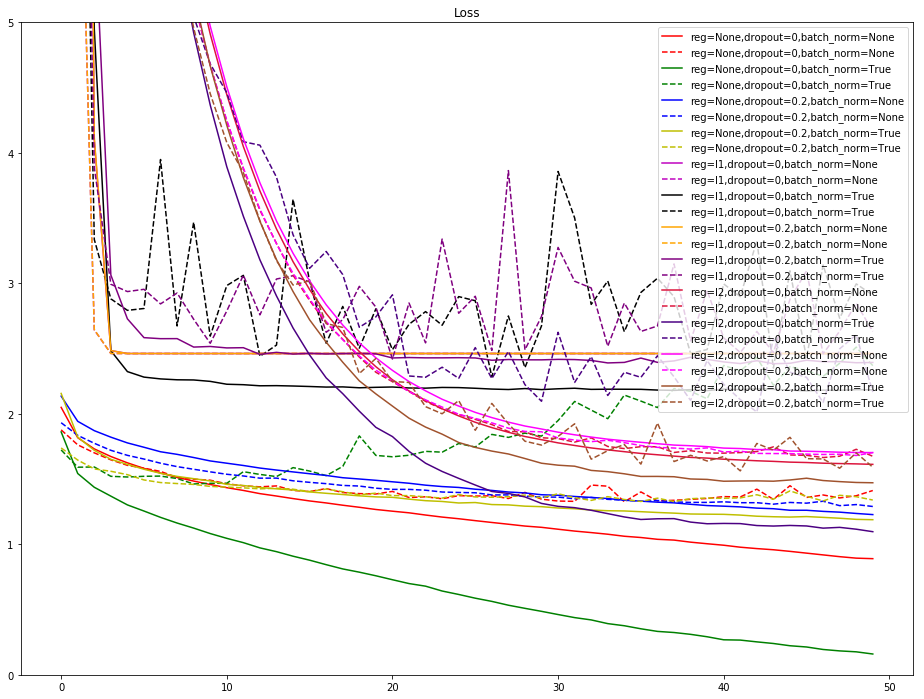

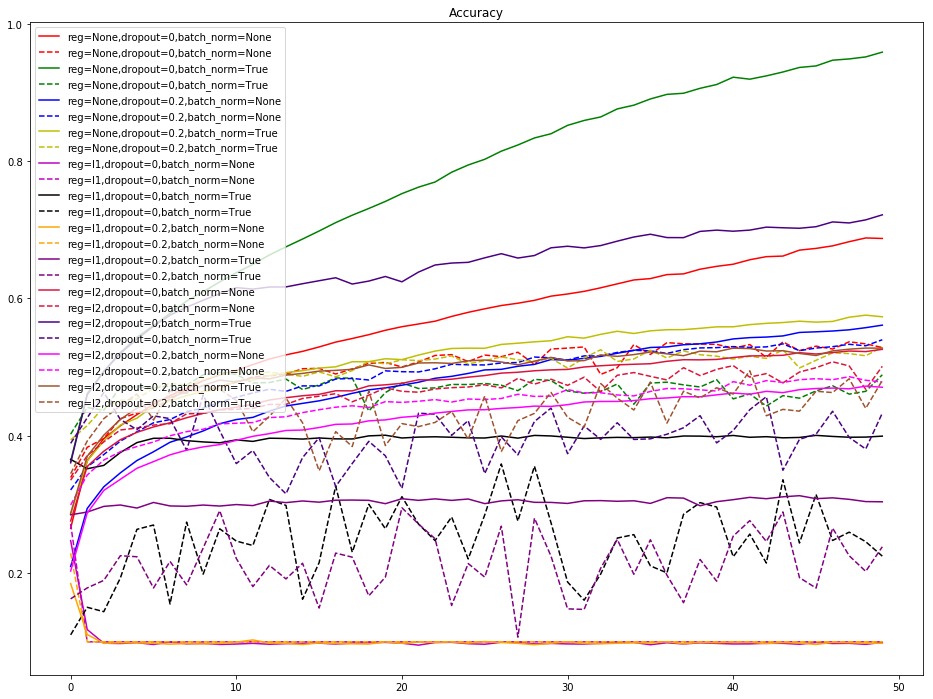

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "orange", "purple", "crimson", "indigo", "magenta", "sienna"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()